# Beginning

In [ ]:
!rm -R nlp2021-hw1
!git clone https://github.com/SapienzaNLP/nlp2021-hw1
!mv nlp2021-hw1/data data
!rm -R nlp2021-hw1


rm: cannot remove 'nlp2021-hw1': No such file or directory
Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
import json, re
import random
import copy
from typing import *
from tqdm.notebook import tqdm
from collections import defaultdict
import numpy as np
from itertools import combinations
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sb
sb.set()

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import random

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

class DeviceObject(object):
    device='cuda'

    def __init__(self):
        self.to(self.device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!rm glove.6B.zip

--2021-05-02 08:13:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-02 08:13:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-02 08:13:17--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# Class for loading embeddings

In [ ]:
class VectorsWithSpecials(DeviceObject):
    '''
    Class for loading embeddings from a file
    '''
    def __init__(self, file_name):
        self.__load_data(file_name)
        self.length = len(self.itos)

        self.add_unk_and_pad_token()
    
    def __load_data(self, file_name: str):
        # Initialization for 3 main objects of this class
        self.stoi = {} # Dictionary of Token name -> Token id 
        self.itos = [] # List of Token id -> Token name
        self.vectors = [] # List with embeddings
        
        with open(file_name, 'r') as file:
            lines = file.readlines()
            for i, line in tqdm(enumerate(lines)):
                values = line.split(' ')
                token_str = values[0]
                self.stoi[token_str] = i
                self.itos.append(token_str)
                self.vectors.append(list(map(float, values[1:])))

        self.vectors = torch.tensor(self.vectors, device=self.device)

    def __getitem__(self, token):
        if type(token) == int:
            return self.vectors[token]
        else:
            return self.vectors[self.stoi[token]]

    def add_special(self, token: str, vec: torch.Tensor):
        '''
        Adding special tokens to our data

        Parameters
        ----------
        token : str
            name of token like '<unk>'
        vec : torch.Tensor
            embedding vector

        Returns
        -------
        None.

        '''
        self.stoi[token] = self.length
        self.itos.append(token)
        self.vectors = torch.cat((self.vectors, vec.reshape(1, -1)))
        
        self.length += 1

    
    def get_id(self, token: str):
        '''
        Returns id of token by its name

        '''
        if token not in self.stoi:
            return self.stoi['<unk>']
        else:
            return self.stoi[token]


    def add_unk_and_pad_token(self, num_of_ave: int=50000):
        '''
        Idea for averaging vectors for <unk> representation is taken from:
        https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
        '''
        vectors = self
        vec = torch.zeros(vectors[0].shape, device=self.device)
        for i in range(num_of_ave):
            vec += vectors[vectors.itos[i]] / num_of_ave

        # Adding special tokens
        vectors.add_special('<unk>', vec)
        vectors.add_special('<pad>', vectors[0])
        vectors.add_special('<sep>', torch.rand(vectors[0].shape, device=self.device))
        # Masked token is used for Context Encoder (language model)
        vectors.add_special('<masked>', torch.rand(vectors[0].shape, device=self.device))


vectors = VectorsWithSpecials("glove.6B.300d.txt")
vectors_50 = VectorsWithSpecials("glove.6B.50d.txt")

# Dataset

In [ ]:
class WiCDataset(Dataset, DeviceObject):
    # POS tags in original dataset
    pos_to_id = {'ADJ': 0, 'ADV': 1, 'NOUN': 2, 'VERB': 3, 'UNK' : 4}
    # NLTK POS tags
    nltk_pos_tags = {name:i for i, name in enumerate(['IN', 'DT', 'NN', 'CC', 'VBZ', 'JJ', 'VBD', 'RB', 'VBN', 'CD', 'NNS', 'WRB', 'PRP', 'WP', 'VBP', 'TO', 'VB', 'VBG', 'PRP$', 'MD', 'NNP', 'JJR', 'WDT', 'RBS', 'EX', 'RP', 'PDT', 'RBR', 'JJS', 'WP$', 'FW', '$', 'NNPS', 'POS', 'SYM', 'UH'])}
    num_pos_classes = len(nltk_pos_tags.keys())
    
    def __init__(self, file_path_or_list, # OR List with sentences 
                 vocab: VectorsWithSpecials,
                 wrong_label_prob=0, # An option to have some noise among labels with specified probability
                 swap_sequences=False,
                 swap_tokens=None,
                 rand_replace=None,  # Threshold in percentages of replaced tokens
                 rand_replace_mode='sample_words', # OR 'unk_tokens'
                 max_length=None,
                 mask_word_mode=False,
                 remove_stop_words=False,
                 lemmatization=False,
                 with_pos_tags = False, # Used for extra model with POS tags
                 ):
        self.vocab = vocab
        counter_names = ['label', 'lemma', 'pos', 'token', 'sen_length', 'masked_word', 'unk_tokens', 'tags']
        self.counter = {field_name: defaultdict(int) for field_name in counter_names}
        self.augmented_db = {'True': defaultdict(set), 'False': []}
        self.wrong_label_prob = wrong_label_prob
        self.swap_sequences = swap_sequences
        self.swap_tokens = swap_tokens
        self.max_length = max_length
        self.rand_replace = rand_replace
        self.get_counter = 0
        self.mask_word_mode = mask_word_mode
        self.remove_stop_words = remove_stop_words
        self.stopwords = stopwords.words('english')
        self.stopwords_indecies = {vocab.stoi[s] for s in self.stopwords if s in vocab.stoi}
        self.replacement_function = getattr(self, rand_replace_mode)
        self.with_pos_tags = with_pos_tags
        
        self.lemmatyzer = WordNetLemmatizer() if lemmatization else None

        self.load_data(file_path_or_list)
        # Inititalization of array with words to be sampled for replacement or negative sampling
        self.init_arr_for_sampling()

        self.max_length = max(self.counter['sen_length'].keys())   

    def __len__(self):
        if self.mask_word_mode:
            return len(self.sentences)
        else:
            return len(self.data)

    def __getitem__(self, idx: int):
        '''
        The function works in two modes: 
            1) Masking mode - randomly choose one sentence from data 
            and replace randomly one word with <masked> token
            2) Original mode - randomly choose an item from original data 
            with 2 sentences. Returns tokens for sentences and positions of lemma

        '''
        if self.mask_word_mode:
            tokens = copy.deepcopy(self.sentences[idx])
            # Choosing which word to replace
            rand_idx = torch.randint(len(tokens), (1,)).item()
            token_id = tokens[rand_idx].item()
            tokens[rand_idx] = self.vocab.get_id('<masked>')
            # Gathering masked tokens statistics
            self.counter['masked_word'][token_id] += 1

            # Toss a coin
            if torch.rand(1).item() >= 0.5:
                # Negative sample
                token_id = self.sample_words(1).item()
                label = 0
            else:
                # Keeping original word
                label = 1

            # Data augmentation
            if self.rand_replace is not None:
                tokens = self.replace_rand_words(tokens, [rand_idx])
            if self.swap_tokens is not None:
                tokens = self.swap_rand_tokens(tokens, [rand_idx])
            
            item = {'tokens' : tokens, 'unk_position': rand_idx, 
                    'token_id': token_id, 'seq_length': len(tokens), 
                     'label': label}

            if self.with_pos_tags:
                item['tags'] = self.all_tags[idx]
            
            return item
        else:
            data = copy.deepcopy(self.data[idx])
            # If wrong label probability is set, we add noise in labels. 
            # It might be used to reduce overfitting
            if self.wrong_label_prob > 0 and torch.rand(1)[0].item() < self.wrong_label_prob:
                data['label'] = 1.0 - data['label']
            
            # Data augmentation
            if self.rand_replace is not None:
                for i in range(1, 3):
                    data['tokens' + str(i)] = self.replace_rand_words(data['tokens' + str(i)], [data['where_lemma' + str(i)]])
            if self.swap_tokens is not None:
                for i in range(1, 3):
                    data['tokens' + str(i)] = self.swap_rand_tokens(data['tokens' + str(i)], [data['where_lemma' + str(i)]])
            
            return data

    def init_arr_for_sampling(self):
        '''
        Array for sampling from is constructed by simply appending in 
        a list a token id as maby time as it appears in corpus

        '''
        arr_for_sampling = []
        for token, freq in sorted(self.counter['token'].items(), key=lambda x: -x[1]):
            # Excluding stopwords from samples
            if token not in self.stopwords:
                arr_for_sampling += [token] * freq

        self.arr_for_sampling = torch.tensor(arr_for_sampling, device=self.device)

    def sample_words(self, num: int):
        '''
        Since we have a big list filled with token ids occured as many times as in corpus,
        we just generate random numbers and used them as ids

        Parameters
        ----------
        num : number of samples

        Returns
        -------
        Tensor with tokens ids

        '''
        return self.arr_for_sampling[torch.randint(len(self.arr_for_sampling), (num,), device=self.device)]

    def unk_tokens(self, num):
        '''
        Generates tensor filled with <unk> token

        '''
        return torch.tensor([self.vocab.get_id('<unk>')] * num, dtype=torch.int64, device=self.device)

    def replace_rand_words(self, tokens, exclude):
        '''
        Data augmentation with random replacement of words

        Parameters
        ----------
        tokens : tensor with tokens ids
        exclude : list of positions to excluded from replacement. For example, id of masked token

        Returns
        -------
        tokens : modified tokens tensor

        '''
        # Maximum number of changes that can be done: sentence length multiplied by specified percentage 
        num = int(len(tokens) * self.rand_replace) + 1
        # Exact number of changes to be made
        num = torch.randint(num, (1,)).item()
        if num > 0:
            # Randomly permuted tokens cut with 'num' size and converted to set, then excluded set is substracted.
            rand_idx = torch.tensor(list(set(torch.randperm(len(tokens))[:num].tolist()) - set(exclude)), 
                                    dtype=torch.int64,
                                    device=self.device)
            # Replacement function either 'sample_tokens' or 'unk_tokens' - replace chosen tokens with <unk>
            tokens[rand_idx] = self.replacement_function(len(rand_idx))

        return tokens

    def swap_rand_tokens(self, tokens, exclude):
         # Maximum number of changes that can be done: sentence length multiplied by specified percentage 
        num = int(len(tokens) * self.swap_tokens) + 1
        # Exact number of changes to be made
        num = torch.randint(num, (1,)).item()
        if num > 0:
            # Randomly permuted tokens cut with 'num' size and converted to set, then excluded set is substracted.
            rand_idx = torch.tensor(list(set(torch.randperm(len(tokens))[:num].tolist()) - set(exclude)), 
                                    dtype=torch.int64,
                                    device=self.device)
            
            # Make chosen list of ids to be even size
            size = (len(rand_idx) // 2) * 2
            rand_idx = rand_idx[:size]
            # Swap tokens
            tokens[rand_idx[:size // 2]] = tokens[rand_idx[size // 2:]]

        return tokens

    def pre_process(self, token):
        '''
        This is function for optional lemmatization using external library like NLTK
        '''
        if self.lemmatyzer:
            token = self.lemmatyzer.lemmatize(token)
        
        return token

    def load_data(self, file_path_or_list: str):
        '''
        Data loading is performed in two modes:
        1) If file name is set in 'file_path_or_list' field, then we parse file
        2) If a list is set then we parse a list
        '''
        if type(file_path_or_list) == str:
            # The file block
            file_path = file_path_or_list
            with open(file_path, 'r') as file:
                self.__init_data(file.readlines())
        else:
            # The list block
            lines = file_path_or_list
            self.__init_data(lines, is_json=False)
        

    def __init_data(self, lines, is_json=True):
        '''
        Transforms original dataset format in one that is useful for training models,
        in particular:  splitting text to tokens, converting labels from string to numbers,
        collecting pos tags if the flag is set. 
        '''
        data = []
        sentences = []
        all_tags = []
        
        for i, line in tqdm(enumerate(lines)):
            # Parsing json
            obj = json.loads(line) if is_json else line

            row = { 
                # If POS tags is not in our dictionary we set it to UNK
                'pos': self.pos_to_id[obj['pos']] if obj['pos'] in self.pos_to_id else self.pos_to_id['UNK']
            }

            if 'label' in obj:
                # Converting label to number
                row['label'] = (obj['label'] == 'True') * 1.0
                # Collecting labels statistics
                self.counter['label'][obj['label']] += 1

            # Collecting some statistics of POSs and lemmas
            self.counter['pos'][obj['pos']] += 1
            self.counter['lemma'][(obj['lemma'], obj['pos'])] += 1

            continue_flag = False

            for k in [1, 2]:   
                k = str(k)
                pos = int(obj['start' + k])
                # Inserting ** symbols to distinguish word of interest
                mod_sentence = obj['sentence' + k] = obj['sentence' + k][:pos] + '**' + obj['sentence' + k][pos:]
                
                # Transforming text to token ids and getting position of lemma
                tokens_ids, where_lemma = self.text_to_token_ids(mod_sentence)
                
                row['tokens' + k] = tokens_ids
                row['where_lemma' + k] = where_lemma
                
                if self.with_pos_tags:
                    row['tags' + k] = tags = self.pos_tags(obj['sentence' + k])
                    all_tags.append(tags)
                
                # There is an option to limit length of sentences
                if self.max_length is not None and len(tokens_ids) > self.max_length:
                    continue_flag = True
                    continue 

                self.counter['sen_length'][len(tokens_ids)] += 1
                sentences.append(tokens_ids)

            if continue_flag:
                continue
            
            data.append(row)
            
            # Swap indecies 
            if self.swap_sequences:
                swapped_row = row.copy()
                swapped_row['tokens1'], swapped_row['tokens2'] = swapped_row['tokens2'], swapped_row['tokens1']
                swapped_row['where_lemma1'], swapped_row['where_lemma2'] = swapped_row['where_lemma2'], swapped_row['where_lemma1']

                data.append(swapped_row)     
        
        # Storing collected data
        self.data = data
        self.sentences = sentences
        self.all_tags = all_tags


    def tokenize(self, text: str) -> List:
        '''
        Performs splitting text into strings tokens
        '''
        return re.split('[^\w\*]', text.lower())

    def pos_tags(self, text: str) -> List:
        '''
        Takes sentence text and returns POS tags of each word
        '''
        tokens = [t for t in self.tokenize(text) if t]

        _tags = nltk.pos_tag(tokens)
        tags = []

        for _, tag in _tags:
            self.counter['tags'][tag] += 1
            tags.append(self.nltk_pos_tags[tag])
        
        return tags

    def text_to_token_ids(self, text: str) -> List:
        '''
        Converts text to list of tokens ids from embeddings vocaulary
        '''
        # Splitting by regular expression
        tokens = re.split('[^\w\*]', text.lower())
        where_lemma = -1
        tokens_ids = []
        # Excluding empty string and stopwords if required,  and adding tokens to the list. 
        tokens = [self.pre_process(t) for t in tokens if t != '' and not (self.remove_stop_words and t in self.stopwords)]

        for i in range(len(tokens)):
            t = tokens[i]
            # If a word contain ** at the beggining, then this is our lemma of intereset
            if t[:2] == '**':
                where_lemma = i
                t = t.replace('**', '')

            tokens_ids.append(self.vocab.get_id(t))
            # Collection statistics of tokens
            self.counter['token'][tokens_ids[-1]] += 1
            
            if tokens_ids[-1] == self.vocab.get_id('<unk>'):
                self.counter['unk_tokens'][t] += 1

        assert where_lemma != -1

        return torch.tensor(tokens_ids).to(self.device), where_lemma

    def get_used_tokens(self, remove_stop_words=False):
        '''
        Return tokens that are in corpus
        '''
        tokens = set(train_dataset_context.counter['token'].keys())
        if remove_stop_words:
            tokens -= self.stopwords_indecies

        return tokens

# Train - Evaluate

In [ ]:
def binary_accuracy(preds, targets, treshold=0.5):
    return torch.mean(((preds >= treshold)*1.0 == targets) * 1.0)

def first_approach_train_step(model, batch):
    sen_token_1, sen_token_2, label = batch
    preds, loss = model(sen_token_1, sen_token_2, label)
    
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, label)}

def first_approach_eval_step(model, batch):
    sen_token_1, sen_token_2, label = batch
    preds, loss = model(sen_token_1, sen_token_2, label)

    return loss, binary_accuracy(preds, label)

def train(train_data_loader, valid_data_loader, model, optimizer, 
          train_step, eval_step, epochs, 
          best_model={}, best_model_mode='valid_loss', hist={}, scheduler=None):
    '''
    Main function for training.
    train_step - function for executing one batch step
    eval_step - function for evaluation of one batch
    best_model - stores best model
    best_model_mode - either 'valid_loss' or 'accuracy'
    hist - stores history of losses and validation accuracy
    '''
    best_score = -np.inf
    hist['train_loss'], hist['valid_loss'], hist['valid_accuracy'] = [], [], []
    

    for epoch in range(epochs):
        epoch_hist = defaultdict(list)
        losses = []
        model.train()

        for i, batch in enumerate(train_data_loader):
            model.zero_grad()
            
            res = train_step(model, batch)
            loss = res['loss']

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            if 'batch_accuracy' in res:
                epoch_hist['batch_accuracy'].append(res['batch_accuracy'])

        mean_loss = sum(losses) / len(losses)
        valid_mean_loss, valid_batch_accuracy = evaluate(valid_data_loader, model, eval_step)
        print(f'Epoch {epoch}: Loss: {mean_loss:0.6f} \t\t Validation loss: {valid_mean_loss:0.6f}')

        # If score of interes is validation loss we make it with negative sign to keep comparison the same for both cases
        score_to_compare = -valid_mean_loss if best_model_mode == 'valid_loss' else valid_batch_accuracy
        if score_to_compare > best_score:
            # Storing the best model so far
            best_score = score_to_compare
            best_model['best_score'] = abs(score_to_compare)
            best_model['state_dict'] = copy.deepcopy(model.state_dict())
            print('BEST SCORE:', best_model['best_score'])

        if 'batch_accuracy' in epoch_hist:
            train_accuracy = sum(epoch_hist['batch_accuracy']) / len(epoch_hist['batch_accuracy'])
            print(f'Training average batch accuracy: {train_accuracy:0.6f}')

        # Storing history
        hist['train_loss'].append(mean_loss)
        hist['valid_loss'].append(valid_mean_loss)
        hist['valid_accuracy'].append(valid_batch_accuracy.item())

        if scheduler:
            scheduler.step(valid_mean_loss)

        print(f'Validation average batch accuracy: {valid_batch_accuracy:0.6f}')\
    
    return best_model, model

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    ''' 
    Model evaluation function
    eval_step - function to be executed for each batch
    '''
    model.eval()
    results = []
    losses = []

    for i, batch in enumerate(data_loader):
        loss, metric = eval_step(model, batch)
        losses.append(loss.item())
        results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)

def plot_hist(hist, window=10):
    '''
    Plots moving averages of loses and accuracy
    hist - dictionary containing training history
    window - window size of moving average
    '''
    df = pd.DataFrame(list(zip(hist['train_loss'], hist['valid_loss'])), columns=['train_loss', 'valid_loss'])
    df.rolling(window).mean().plot()

    pd.DataFrame(hist['valid_accuracy'], columns=['valid_accuracy']).rolling(window).mean().plot()

# First approcah model

In [ ]:
# For GloVe 50
class HypParams:
    hidden_size = 100
    dropout=0.6


class FirstApproachModel(nn.Module):
    '''
    The model averages separetly embeddings for each sentence concatenate them and feed to MLP.
    There is also option to transform them and check cosine similiarity.
    '''
    def __init__(self, params, 
                 embeddings, 
                 cosine_mode=False 
                 ):
        super().__init__()
        # If cosine mode is set we do not concatentae vectors but compare via cosine similiarity
        self.cosine_mode = cosine_mode
        input_size = embeddings[0].shape[0]
        
        # Loading pre-trained embedding from our vocabulary
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
  
        if cosine_mode:
            # For cosine mode we should get vectors to compare so output size if multi-dimensional
            output_size = params.hidden_size
        else:
            # For classification output is of dimension 1 
            input_size = input_size * 2
            output_size = 1

        # MLP sequence
        self.sequence = nn.Sequential(
            nn.Linear(input_size, params.hidden_size),
            nn.BatchNorm1d(params.hidden_size),
            nn.ReLU(params.hidden_size),
            nn.Dropout(p=params.dropout),

            nn.Linear(params.hidden_size, output_size),
        )

        self.cosine = nn.CosineSimilarity()
        self.loss = nn.BCELoss()

    def forward(self, tokens_1, tokens_2, y=None):
        emb_1 = torch.mean(self.word_embeddings(tokens_1), dim=1)
        emb_2 = torch.mean(self.word_embeddings(tokens_2), dim=1)

        if self.cosine_mode:
            results = []
            for emb in [emb_1, emb_2]:
                results.append(self.sequence(emb))

            # Transformation of cosine similiaity so we have value in interval of [0, 1]
            res = (self.cosine(results[0], results[1]) + 1) / 2
        else:
            # Concatenation of vectors and feeding them to classifier
            res = self.sequence(torch.cat((emb_1, emb_2), dim=-1))
            res = torch.sigmoid(res).squeeze()

        loss = self.loss(res, y) if y is not None else None
            
        return res, loss


class PadCollator(DeviceObject):
    '''
    Collator for loader which produces padded tensors
    '''

    def __init__(self, pad_token_id):
        self.pad_token_id = pad_token_id
    
    def __call__(self, batch):
        sen_token_1 = [b['tokens1'] for b in batch]
        sen_token_2 = [b['tokens2'] for b in batch]
        label = [b['label'] for b in batch]

        sen_token_1 = torch.nn.utils.rnn.pad_sequence(sen_token_1, batch_first=True, padding_value=self.pad_token_id)
        sen_token_2 = torch.nn.utils.rnn.pad_sequence(sen_token_2, batch_first=True, padding_value=self.pad_token_id)
        
        return sen_token_1.to(self.device), sen_token_2.to(self.device), torch.tensor(label).to(self.device)
    

train_dataset = WiCDataset('data/train.jsonl', vectors_50, 
                           rand_replace=0.2, 
                           #rand_replace_mode='unk_tokens',
                           remove_stop_words=True, 
                           wrong_label_prob=0)

valid_dataset = WiCDataset('data/dev.jsonl', vectors_50, remove_stop_words=True,)

collate_obj = PadCollator(vectors_50.get_id('<pad>'))

batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_obj)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_obj)

In [ ]:
model = FirstApproachModel(HypParams(), vectors_50.vectors).to('cuda')
optim = torch.optim.Adam(model.parameters())
hist = {}

_ = train(train_loader, 
      valid_loader, 
      model, optim, 
      first_approach_train_step, 
      first_approach_eval_step,
      60, hist=hist, best_model_mode='accuracy',)

Epoch 0: Loss: 0.710733 		 Validation loss: 0.675715
BEST SCORE: tensor(0.5781, device='cuda:0')
Training average batch accuracy: 0.513750
Validation average batch accuracy: 0.578125
Epoch 1: Loss: 0.687916 		 Validation loss: 0.659783
BEST SCORE: tensor(0.6348, device='cuda:0')
Training average batch accuracy: 0.551125
Validation average batch accuracy: 0.634766
Epoch 2: Loss: 0.677728 		 Validation loss: 0.658229
Training average batch accuracy: 0.577500
Validation average batch accuracy: 0.607227
Epoch 3: Loss: 0.670584 		 Validation loss: 0.644648
BEST SCORE: tensor(0.6438, device='cuda:0')
Training average batch accuracy: 0.581250
Validation average batch accuracy: 0.643750
Epoch 4: Loss: 0.664976 		 Validation loss: 0.642426
BEST SCORE: tensor(0.6496, device='cuda:0')
Training average batch accuracy: 0.595500
Validation average batch accuracy: 0.649609
Epoch 5: Loss: 0.657962 		 Validation loss: 0.638389
Training average batch accuracy: 0.605125
Validation average batch accuracy:

In [ ]:
# Percenatage of <unk> 
sum(train_dataset.counter['unk_tokens'].values()) / sum(list(train_dataset.counter['token'].values())) * 100

0.7770800627943485

## Plots

### Ratio of all words in corpus to OOV words


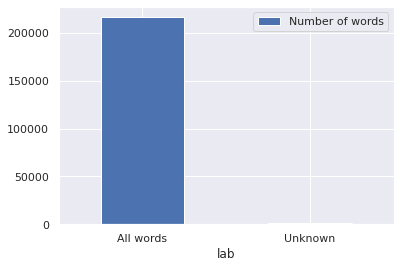

In [ ]:
pd.DataFrame({'Number of words': [sum(list(train_dataset.counter['token'].values())), 
                                 sum(train_dataset.counter['unk_tokens'].values())], 
              'lab': ['All words', 'Unknown']}).plot.bar(x='lab', rot=0)

### Comparison of training procedure with random replacement and without

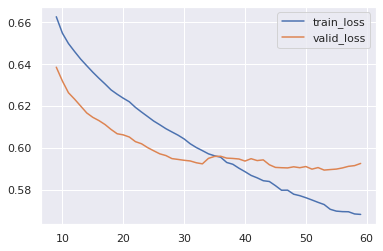

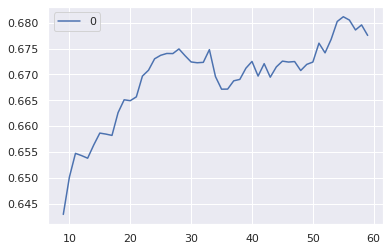

In [ ]:
plot_hist(hist)

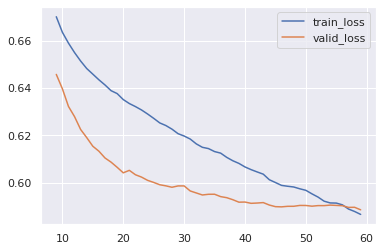

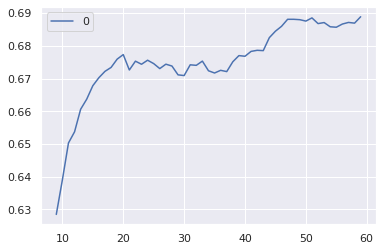

In [ ]:
# dropout 0.6  rand_replace=0.2
plot_hist(hist)

# Context encoder (CE)

## Dataloader for dataset for language model

In [ ]:
def context_train_step(model, batch):
    loss, _ = model(*list(batch))
    return {'loss': loss}

def context_eval_step(model, batch):
    loss, _ = model(*list(batch))
    return {'loss': loss}


class PadCollator_2(DeviceObject):
    '''
    Collator for dataloader for Context Encoder part: consider one sentence at the time; 
    makes paddings in sentences and in tags; include tags if include_pos_tags is set
    '''
    def __init__(self, pad_token_id, include_pos_tags=False, pad_tag_id=None):
        self.pad_token_id = pad_token_id
        self.pad_tag_id = pad_tag_id
        self.include_pos_tags = include_pos_tags
    
    def __call__(self, batch):
        seq_length = torch.tensor([b['seq_length'] for b in batch], device=self.device)
        tokens = [b['tokens'] for b in batch]
        masked_id = torch.tensor([b['token_id'] for b in batch], device=self.device)
        labels = torch.tensor([b['label'] for b in batch], dtype=torch.float, device=self.device)
        
        # Padding of sentences
        tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=self.pad_token_id).to(self.device)
        shape = tokens.shape

        unk_position = torch.tensor([b['unk_position'] for b in batch], device=self.device).unsqueeze(1)
        # Making one hot encoding representation of position of masked token
        unk_position = torch.zeros(shape[0], shape[1], dtype=torch.int, device=self.device).scatter(1, unk_position, 1)
        
        if self.include_pos_tags:
            tags = [torch.tensor(b['tags']) for b in batch]
            # Padding of tags
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=self.pad_tag_id).to(self.device)
            tags[unk_position == 1] = self.pad_tag_id
            
            return  tokens, unk_position, tags, masked_id, labels

        return  tokens, unk_position, masked_id, labels

MAX_LENGTH = None
include_pos_tags = False
train_dataset_context = WiCDataset('data/train.jsonl', vectors, mask_word_mode=True,
                                   rand_replace=0.1,
                                   swap_tokens=0.3,
                                   with_pos_tags=include_pos_tags,
                                   #rand_replace_mode='unk_tokens',
                                   #lemmatization=True,
                                   remove_stop_words=not include_pos_tags, # If we include tags we do not remove stopwords
                                   max_length=MAX_LENGTH)
valid_dataset_context = WiCDataset('data/dev.jsonl', vectors, 
                                   #lemmatization=True,
                                   with_pos_tags=include_pos_tags,
                                   mask_word_mode=True, 
                                   remove_stop_words=not include_pos_tags,
                                   )

collate_obj = PadCollator_2(vectors.get_id('<pad>'), 
                            include_pos_tags=include_pos_tags, pad_tag_id=train_dataset_context.num_pos_classes)

batch_size = 64
train_loader_context = DataLoader(train_dataset_context, 
                                  shuffle=True, batch_size=batch_size, collate_fn=collate_obj)
valid_loader_context = DataLoader(valid_dataset_context, 
                                  batch_size=batch_size, collate_fn=collate_obj)

## Model CE

In [ ]:
class ContextParams:
    dropout = 0.7
    bidirectional = True
    num_layers = 2
    attention_dropout=0.7
    max_length=train_dataset_context.max_length

    # POS Mode
    pos_classes = WiCDataset.num_pos_classes
    pos_embed_dim = 100

class ContextEncoder(nn.Module, DeviceObject):
    '''
    Language model that mask a word and it is trained to predict if a given word fit to context.
    We use negative sampling so we concatenate output from LSTM with either word embedding of real token 
    or token sampled randomly from corpus with probability to occur as it is present in the corpus.
    '''
    def __init__(self, params, vocab, 
                 cosine_mode=False, # In cosine mode we 
                 with_pos_tags=False, # Include POS tags from NLTK library
                 multi_learn=False # This option was not fully implemented
                 ): 
        super().__init__()
        self.with_pos_tags = with_pos_tags
        self.vocab = vocab
        self.cosine_mode = cosine_mode
        self.multi_learn = multi_learn

        embeddings = vocab.vectors
        input_size = embeddings[0].shape[0]
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)

        rnn_out_size = input_size * 2
        self.rnn = nn.LSTM(input_size + (params.pos_embed_dim if with_pos_tags and not multi_learn else 0), rnn_out_size, 
                            bidirectional=params.bidirectional,
                            num_layers=params.num_layers, 
                            dropout=params.dropout,
                            batch_first=True)
        
        self.rnn_2 = nn.LSTM(rnn_out_size * 2, rnn_out_size, 
                            bidirectional=params.bidirectional,
                            num_layers=params.num_layers, 
                            dropout=params.dropout,
                            batch_first=True)
        
        # There was attention before so var name is left :) - it is size of hidden layer in classifier
        attn_input_dim = rnn_out_size * (2 if params.bidirectional else 1)
        
        self.vocab_size = len(vocab.itos)

        self.classifier = nn.Sequential(
            nn.Linear(input_size*5, attn_input_dim * 4),
            nn.BatchNorm1d(attn_input_dim * 4),
            nn.ReLU(),
            nn.Dropout(p=params.attention_dropout),

            nn.Linear(attn_input_dim * 4, 1)
        )
        if cosine_mode:
            # Transformation MLP
            self.transform = nn.Sequential(
                nn.Linear(input_size*4, input_size*4),
                nn.BatchNorm1d(input_size*4),
                nn.ReLU(),
                nn.Dropout(p=params.attention_dropout),

                nn.Linear(input_size*4, input_size)
            )
            self.cosine = nn.CosineSimilarity()
        
        self.loss = nn.BCELoss()

        if with_pos_tags:
            if multi_learn:
                self.pos_classier = nn.Sequential(
                    nn.Linear(input_size*4, input_size*2),
                    nn.BatchNorm1d(input_size*2),
                    nn.ReLU(),
                    nn.Dropout(p=params.attention_dropout),

                    nn.Linear(input_size*2, params.pos_classes + 1)
                )
                self.pos_loss = nn.CrossEntropyLoss()
            else:
                self.pos_embeddings = nn.Embedding(params.pos_classes + 1, params.pos_embed_dim,)
            
        self.to(self.device)
    
    def forward(self, *args):
        # Forward function depends on whether we use POS tags or not
        if self.with_pos_tags:
            return self.pos_tag_forward(*args)
        else:
            return self.main_forward(*args)

    def main_forward(self, tokens, unk_position, token_id=None, target=None, tags=None):
        seq_embeds = self.word_embeddings(tokens)
        input_shape = seq_embeds.shape

        if tags is not None:
            if not self.multi_learn:
                tags_embeds = self.pos_embeddings(tags)
                seq_embeds = torch.cat((seq_embeds, tags_embeds), dim=-1)

        # Staking two Bi-LSTMs
        rnn_out, (h, c) = self.rnn(seq_embeds)
        rnn_out, (h, c) = self.rnn_2(rnn_out)

        # Taking RNN output only in position of masking token
        unk_context = rnn_out[unk_position == 1]

        out_for_loss, loss,  = None, None
        # Transformation in case of cosine mode
        trans_vector = self.transform(unk_context) if self.cosine_mode else None
        
        # Training part
        if token_id is not None:
            if len(token_id.shape) == 2:
                word_embeddings = token_id
            else:
                word_embeddings = self.word_embeddings(token_id)
            
            if self.cosine_mode:
                # Transforming so value is in [0, 1]
                out_for_loss = (self.cosine(word_embeddings, trans_vector) + 1)/2
            else:
                # Normal mode part
                to_classify = torch.cat((
                    word_embeddings, 
                    unk_context,
                    ), dim=-1)

                out_for_loss = self.classifier(to_classify)
                out_for_loss = torch.sigmoid(out_for_loss).squeeze()

            # Multi-task learning block
            extra_loss = 0
            if self.multi_learn:
                tag_target = tags[unk_position == 1]
                extra_loss = self.pos_loss(self.pos_classier(unk_context), tag_target)
            
            # Caclulating overall loss
            loss = self.loss(out_for_loss, target) + extra_loss

        return (unk_context, trans_vector), out_for_loss, loss

    def pos_tag_forward(self, *args):
        '''
        Different from main_forward in sequence of parameters that we should place to forward 
        '''
        if len(args) == 3:
            token_id, target, tags = [None] * 3
            tokens, unk_position, tags = args
        else:
            tokens, unk_position, tags, token_id, target = args
        
        return self.main_forward(tokens, unk_position, token_id, target, tags)
        #raise 'No pos tagging yet!!! Gotcha ;)'

In [ ]:
def context_train_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def context_eval_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return loss, binary_accuracy(preds, batch[-1])

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    '''
    Since validation loss is noisy because of presence of negative samples,
    we average N times it to see kind of real value 
    '''
    model.eval()
    results = []
    losses = []
    
    for k in range(10):
        for i, batch in enumerate(data_loader):
            loss, metric = eval_step(model, batch)
            losses.append(loss.item())
            results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)



model_context = ContextEncoder(ContextParams(), vectors, 
                               #cosine_mode=True,
                               with_pos_tags=False,
                               multi_learn=False
                               )
optim_context = torch.optim.Adam(model_context.parameters(), lr=0.0001)

# We didn't see any effect of scheduler in this problem, but we kept it
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.9, verbose=True)
scheduler=None

best_model = {}
hist = {}

best_state_dict, _ = train(train_loader_context, valid_loader_context, 
      model_context, optim_context, 
      context_train_step_2, 
      context_eval_step_2,
      300, best_model, 
      best_model_mode='accuracy', 
      hist=hist,
      scheduler=scheduler)

Epoch 0: Loss: 1.800756 		 Validation loss: 0.793206
BEST SCORE: tensor(0.5082, device='cuda:0')
Training average batch accuracy: 0.507250
Validation average batch accuracy: 0.508154
Epoch 1: Loss: 0.785910 		 Validation loss: 0.723286
BEST SCORE: tensor(0.5151, device='cuda:0')
Training average batch accuracy: 0.504000
Validation average batch accuracy: 0.515137
Epoch 2: Loss: 0.743544 		 Validation loss: 0.711034
BEST SCORE: tensor(0.5170, device='cuda:0')
Training average batch accuracy: 0.506000
Validation average batch accuracy: 0.517041
Epoch 3: Loss: 0.730676 		 Validation loss: 0.698701
BEST SCORE: tensor(0.5195, device='cuda:0')
Training average batch accuracy: 0.508625
Validation average batch accuracy: 0.519482
Epoch 4: Loss: 0.723566 		 Validation loss: 0.697059
Training average batch accuracy: 0.502937
Validation average batch accuracy: 0.514111
Epoch 5: Loss: 0.718267 		 Validation loss: 0.693283
BEST SCORE: tensor(0.5236, device='cuda:0')
Training average batch accuracy:

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save({
            'epoch': 300,
            'model_state_dict': best_model['state_dict'],
            'optimizer_state_dict': optim_context.state_dict()
}, "/content/drive/MyDrive/Sapienza/model_context_GloVE300_nltk_pos_multi_learn.pth" )


# WiC Classifier

## Dataloaders

In [ ]:
seed = 1
set_seed(seed)

class PadCollatorAndLemma(DeviceObject):
    '''
    Everything like in case of CE but for two sentences
    '''
    def __init__(self, pad_token_id, include_pos_tags=False, pad_tag_id=None):
        self.pad_token_id = pad_token_id
        self.pad_tag_id = pad_tag_id
        self.include_pos_tags = include_pos_tags
    
    def __call__(self, batch):
        sen_tokens = []
        where_lemma = []
        tags = []
        
        for k in [0, 1]:
            key = str(k + 1)
            sen_tokens.append([b['tokens' + key] for b in batch])
            
            sen_tokens[-1] = torch.nn.utils.rnn.pad_sequence(sen_tokens[-1], batch_first=True, padding_value=self.pad_token_id)
            shape = sen_tokens[-1].shape

            where_lemma.append(torch.tensor([b['where_lemma' + key] for b in batch]).unsqueeze(1))
            where_lemma[-1] = torch.zeros(shape[0], shape[1], dtype=torch.int).scatter(1, where_lemma[-1], 1)
            sen_tokens[-1].to('cuda')

            if self.include_pos_tags:
                tags.append([torch.tensor(b['tags' + key]) for b in batch]) 
                tags[-1] = torch.nn.utils.rnn.pad_sequence(tags[-1], batch_first=True, padding_value=self.pad_tag_id).to(self.device)

        label = torch.tensor([b['label'] for b in batch]).to(self.device)
        pos = torch.tensor([b['pos'] for b in batch]).to(self.device)

        return where_lemma, sen_tokens, pos, tags, label
    

include_pos_tags=False # Flags for model with extra data - nlts POS tags
train_dataset = WiCDataset('data/train.jsonl', vectors, 
                           rand_replace=0.1,
                           swap_tokens=0.3,
                           wrong_label_prob=0,
                           with_pos_tags=include_pos_tags, 
                           #rand_replace_mode='unk_tokens',
                           #lemmatization=True,
                           remove_stop_words=not include_pos_tags, 
                           swap_sequences=False, max_length=None)
valid_dataset = WiCDataset('data/dev.jsonl', vectors, 
                           #lemmatization=True,
                           with_pos_tags=include_pos_tags,
                           remove_stop_words=not include_pos_tags
                           )

collate_obj = PadCollatorAndLemma(vectors.get_id('<pad>'), include_pos_tags=include_pos_tags, pad_tag_id=WiCDataset.num_pos_classes)

batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_obj)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_obj)

## WiC Model

In [ ]:
set_seed(seed)
class HypParams:
    dropout = 0.95
    pos_classes = 4
    #pos_embed_dim = 30
    pos_embed_dim = 0

class WiCClassifier(nn.Module, DeviceObject):
    '''
    Classifier takes separately each sentence and feed it to Context Encoder 
    which returns contextual representation of lemma in sentence. Then, we classsify it using MLP
    '''

    def __init__(self, params, vocab, context_model, 
                 mask_tokens=False, # An option to mask token like in Context Encoder
                 predict_pos=False, 
                 with_nltk_tags=False):
        super().__init__()
        self.vocab = vocab
        self.context_model = context_model
        self.predict_pos = predict_pos
        self.params = params
        self.mask_tokens = mask_tokens

        embeddings = vocab.vectors
        input_size = embeddings[0].shape[0]
        
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.context_model.eval()

        if params.pos_embed_dim > 0:
            self.pos_embeddings = nn.Embedding(params.pos_classes, params.pos_embed_dim)

        # Main MLP classifer
        self.classifier = nn.Sequential(
            nn.Linear(input_size * 4 * 2 
                      + (params.pos_embed_dim if not predict_pos else 0)
                      , input_size * 4),
            nn.BatchNorm1d(input_size * 4),
            nn.ReLU(),
            nn.Dropout(params.dropout),

            nn.Linear(input_size * 4, 1)
        )
        # This is classifier for multi-tasking 
        self.pos_classifier = nn.Sequential(
            nn.Linear(input_size * 4, params.pos_classes)
        )
        # Extra loss for POS classification used in multi-task mode
        self.pos_loss = nn.CrossEntropyLoss()
        
        self.loss = nn.BCELoss()

    def forward(self, where_lemma, tokens, pos, nltk_pos_tags, y=None): # nltk_pos_tags is empty if it is not indicted in collate object
        contexts = []
        rnn_averages = []
        ave_pos_loss = 0

        for i in range(2):
            main_token_embedding = self.word_embeddings(tokens[i][where_lemma[i] == 1])
            seq_embeds = self.word_embeddings(tokens[i])

            if self.mask_tokens:
                tokens[i][where_lemma[i] == 1] = self.vocab.get_id('<masked>')
            
            with torch.no_grad():
                args = [tokens[i], where_lemma[i]]
                if nltk_pos_tags != []:
                    args.append(nltk_pos_tags[i])

                # Taking context from CE 
                (context, _), _, context_loss = self.context_model(*args) 
                                                              
            contexts.append(context)

        ave_pos_loss = 0
        if self.predict_pos:
            ### Multi-task part
            to_classify = torch.cat(contexts, dim=1)
            # POS classification
            pos_class = self.pos_classifier(self.classifier[:-1](to_classify))
            ave_pos_loss = self.pos_loss(pos_class, pos)
        else:
            ### Part with concatenation of POS embeddings that are trainable
            pos_embeds = [self.pos_embeddings(pos)] if self.params.pos_embed_dim > 0 else []
            # Taking trainable embeddings for POS tags and concatente them with context
            to_classify = torch.cat(contexts + pos_embeds, dim=1)
        
        out = torch.sigmoid(self.classifier(to_classify)).squeeze()

        loss = self.loss(out, y) + ave_pos_loss if y is not None else None
        return out, loss


def train_step_3(model, batch):
    preds, loss = model(*list(batch)[:-1], batch[-1])
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def eval_step_3(model, batch):
    preds, loss = model(*list(batch)[:-1], batch[-1])
    return loss, binary_accuracy(preds, batch[-1])

In [ ]:
@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for i, batch in enumerate(data_loader):
        loss, metric = eval_step(model, batch)
        losses.append(loss.item())
        results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)


model_wic = WiCClassifier(HypParams(), vectors, model_context, 
                            predict_pos=False # multi-learning flag
                          ).to('cuda')

optim_wic = torch.optim.Adam(model_wic.parameters())


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_wic, factor=0.5, verbose=True)

#scheduler=None
best_model = {}
hist = {}

_ = train(train_loader, valid_loader, 
      model_wic, optim_wic, 
      train_step_3, 
      eval_step_3,
      260,
      scheduler=scheduler, 
      best_model_mode='accuracy', 
      best_model=best_model, hist=hist)

In [ ]:
torch.save({
            'epoch': 178,
            'model_state_dict': best_model['state_dict'],
            'optimizer_state_dict': optim_wic.state_dict()
}, "/content/drive/MyDrive/Sapienza/WiC_NEW_no_pos_2.pth" )

# Saved Cells with training procedures

## Context Encoder

### Main model

In [ ]:
def context_train_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def context_eval_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return loss, binary_accuracy(preds, batch[-1])

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for k in range(10):
        for i, batch in enumerate(data_loader):
            loss, metric = eval_step(model, batch)
            losses.append(loss.item())
            results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)



model_context = ContextEncoder(ContextParams(), vectors, 
                               train_dataset_context.get_used_tokens(True), 
                               binary_mode=True,
                               #cosine_mode=True,
                               with_pos_tags=False,
                               ).to('cuda')
optim_context = torch.optim.Adam(model_context.parameters(), lr=0.0001)


#scheduler = torch.optim.lr_scheduler.StepLR(optim_context, 5000, 0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.9, verbose=True)


#scheduler=None
best_model = {}

best_state_dict, _ = train(train_loader_context, valid_loader_context, 
      model_context, optim_context, 
      context_train_step_2, 
      context_eval_step_2,
      300, best_model, 
      best_model_mode='accuracy', 
      scheduler=scheduler)

Epoch 0: Loss: 0.746419 		 Validation loss: 0.706265
BEST SCORE: tensor(0.5493, device='cuda:0')
Training average batch accuracy: 0.507688
Validation average batch accuracy: 0.549316
Epoch 1: Loss: 0.699652 		 Validation loss: 0.669616
BEST SCORE: tensor(0.5817, device='cuda:0')
Training average batch accuracy: 0.565375
Validation average batch accuracy: 0.581689
Epoch 2: Loss: 0.684071 		 Validation loss: 0.668921
BEST SCORE: tensor(0.5958, device='cuda:0')
Training average batch accuracy: 0.585313
Validation average batch accuracy: 0.595850
Epoch 3: Loss: 0.668838 		 Validation loss: 0.633007
BEST SCORE: tensor(0.6344, device='cuda:0')
Training average batch accuracy: 0.598250
Validation average batch accuracy: 0.634424
Epoch 4: Loss: 0.645157 		 Validation loss: 0.621927
BEST SCORE: tensor(0.6480, device='cuda:0')
Training average batch accuracy: 0.628688
Validation average batch accuracy: 0.647998
Epoch 5: Loss: 0.637111 		 Validation loss: 0.632501
Training average batch accuracy:

In [ ]:

torch.save({
            'epoch': 300,
            'model_state_dict': best_model['state_dict'],
            'optimizer_state_dict': optim_context.state_dict()
}, "/content/drive/MyDrive/Sapienza/model_context_GloVE300_swap_replace_to_show.pth" )


### Extra POS tags

In [ ]:
def context_train_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def context_eval_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return loss, binary_accuracy(preds, batch[-1])

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for k in range(10):
        for i, batch in enumerate(data_loader):
            loss, metric = eval_step(model, batch)
            losses.append(loss.item())
            results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)



model_context = ContextEncoder(ContextParams(), vectors, 
                               train_dataset_context.get_used_tokens(True), 
                               binary_mode=True,
                               #cosine_mode=True
                               with_pos_tags=True,
                               ).to('cuda')
optim_context = torch.optim.Adam(model_context.parameters(), lr=0.0001)


#scheduler = torch.optim.lr_scheduler.StepLR(optim_context, 5000, 0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.9, verbose=True)


#scheduler=None
best_model = {}

best_state_dict, _ = train(train_loader_context, valid_loader_context, 
      model_context, optim_context, 
      context_train_step_2, 
      context_eval_step_2,
      300, best_model, scheduler=scheduler)

Epoch 0: Loss: 0.748208 		 Validation loss: 0.695917
BEST SCORE: 0.6959173830226064
Training average batch accuracy: 0.509750
Validation average batch accuracy: 0.545654
Epoch 1: Loss: 0.699311 		 Validation loss: 0.643406
BEST SCORE: 0.6434062253683805
Training average batch accuracy: 0.568438
Validation average batch accuracy: 0.614990
Epoch 2: Loss: 0.651556 		 Validation loss: 0.607569
BEST SCORE: 0.6075685690157115
Training average batch accuracy: 0.622063
Validation average batch accuracy: 0.663232
Epoch 3: Loss: 0.623186 		 Validation loss: 0.581332
BEST SCORE: 0.5813317835330963
Training average batch accuracy: 0.651563
Validation average batch accuracy: 0.683105
Epoch 4: Loss: 0.604053 		 Validation loss: 0.569139
BEST SCORE: 0.5691392871551215
Training average batch accuracy: 0.668063
Validation average batch accuracy: 0.704736
Epoch 5: Loss: 0.588343 		 Validation loss: 0.550592
BEST SCORE: 0.5505923122167588
Training average batch accuracy: 0.685313
Validation average batch

### + Cosine

In [ ]:
def context_train_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def context_eval_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return loss, binary_accuracy(preds, batch[-1])

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for k in range(10):
        for i, batch in enumerate(data_loader):
            loss, metric = eval_step(model, batch)
            losses.append(loss.item())
            results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)



model_context = ContextEncoder(ContextParams(), vectors, 
                               train_dataset_context.get_used_tokens(True), 
                               binary_mode=True,
                               cosine_mode=True,
                               with_pos_tags=False,
                               ).to('cuda')
optim_context = torch.optim.Adam(model_context.parameters(), lr=0.0001)


#scheduler = torch.optim.lr_scheduler.StepLR(optim_context, 5000, 0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.9, verbose=True)


#scheduler=None
best_model = {}

best_state_dict, _ = train(train_loader_context, valid_loader_context, 
      model_context, optim_context, 
      context_train_step_2, 
      context_eval_step_2,
      300, best_model, 
      best_model='accuracy', 
      scheduler=scheduler)

Epoch 0: Loss: 0.684557 		 Validation loss: 0.665980
Training average batch accuracy: 0.553250
Validation average batch accuracy: 0.611377
Epoch 1: Loss: 0.664028 		 Validation loss: 0.652783
Training average batch accuracy: 0.620750
Validation average batch accuracy: 0.636670
Epoch 2: Loss: 0.654639 		 Validation loss: 0.644205
Training average batch accuracy: 0.640688
Validation average batch accuracy: 0.659131
Epoch 3: Loss: 0.648989 		 Validation loss: 0.641474
Training average batch accuracy: 0.653250
Validation average batch accuracy: 0.664990
Epoch 4: Loss: 0.645561 		 Validation loss: 0.638285
Training average batch accuracy: 0.668188
Validation average batch accuracy: 0.672607
Epoch 5: Loss: 0.640959 		 Validation loss: 0.636568
Training average batch accuracy: 0.673438
Validation average batch accuracy: 0.672266
Epoch 6: Loss: 0.641299 		 Validation loss: 0.632887
Training average batch accuracy: 0.674313
Validation average batch accuracy: 0.686182
Epoch 7: Loss: 0.636668 		 

KeyboardInterrupt: ignored

In [ ]:
#torch.save({
            'epoch': 1000,
            'model_state_dict': model_context.state_dict(),
            'optimizer_state_dict': optim_context.state_dict(),
            }, 
           #'model_context_9.pth'
           "/content/drive/MyDrive/Sapienza/model_context_GloVE300_cosine_2.pth"
           )

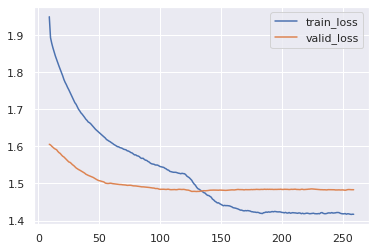

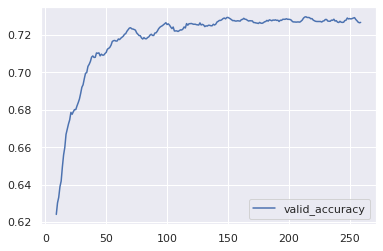

In [ ]:
plot_hist(hist)

#### Classification using cosine

In [ ]:
model_context.eval()
cosine_sim = nn.CosineSimilarity()
trashold = 0.69
accuracy = []
for batch  in valid_loader:
    where_lemma, tokens, pos, tags, y = batch
    contexts = []
    for i in range(2):
        (c, trans_c), _, _ = model_context(tokens[i], where_lemma[i])
        contexts.append(trans_c)
    
    preds = (cosine_sim(contexts[0], contexts[1]) + 1)/2 > trashold
    accuracy.append(binary_accuracy(preds, y))

accuracy = sum(accuracy) / len(accuracy)
print(accuracy)

tensor(0.7117, device='cuda:0')


### WITH STOP WORDS

In [ ]:
def context_train_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return {'loss': loss, 'batch_accuracy': binary_accuracy(preds, batch[-1])}

def context_eval_step_2(model, batch):
    (unk_context, rnn_context), preds, loss = model(*list(batch))
    return loss, binary_accuracy(preds, batch[-1])

@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for k in range(10):
        for i, batch in enumerate(data_loader):
            loss, metric = eval_step(model, batch)
            losses.append(loss.item())
            results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)



model_context = ContextEncoder(ContextParams(), vectors, 
                               train_dataset_context.get_used_tokens(True), 
                               binary_mode=True,
                               #cosine_mode=True,
                               with_pos_tags=False,
                               ).to('cuda')
optim_context = torch.optim.Adam(model_context.parameters(), lr=0.0001)


#scheduler = torch.optim.lr_scheduler.StepLR(optim_context, 5000, 0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.9, verbose=True)


#scheduler=None
best_model = {}

best_state_dict, _ = train(train_loader_context, valid_loader_context, 
      model_context, optim_context, 
      context_train_step_2, 
      context_eval_step_2,
      300, best_model, 
      best_model_mode='accuracy', 
      scheduler=scheduler)

Epoch 0: Loss: 0.753318 		 Validation loss: 0.719353
BEST SCORE: tensor(0.5050, device='cuda:0')
Training average batch accuracy: 0.502250
Validation average batch accuracy: 0.505029
Epoch 1: Loss: 0.734051 		 Validation loss: 0.692494
BEST SCORE: tensor(0.5508, device='cuda:0')
Training average batch accuracy: 0.524000
Validation average batch accuracy: 0.550781
Epoch 2: Loss: 0.706558 		 Validation loss: 0.667323
BEST SCORE: tensor(0.5857, device='cuda:0')
Training average batch accuracy: 0.552125
Validation average batch accuracy: 0.585693
Epoch 3: Loss: 0.685875 		 Validation loss: 0.654890
BEST SCORE: tensor(0.6052, device='cuda:0')
Training average batch accuracy: 0.575438
Validation average batch accuracy: 0.605176
Epoch 4: Loss: 0.675505 		 Validation loss: 0.650742
BEST SCORE: tensor(0.6123, device='cuda:0')
Training average batch accuracy: 0.587438
Validation average batch accuracy: 0.612305
Epoch 5: Loss: 0.669580 		 Validation loss: 0.645241
BEST SCORE: tensor(0.6179, devic

In [ ]:

torch.save({
            'epoch': 300,
            'model_state_dict': best_model['state_dict'],
            'optimizer_state_dict': optim_context.state_dict()
}, "/content/drive/MyDrive/Sapienza/model_context_GloVE300_with_stopwords.pth" )


## WiC Classifier

### WiC no original POS

In [ ]:
@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for i, batch in enumerate(data_loader):
        loss, metric = eval_step(model, batch)
        losses.append(loss.item())
        results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)

model_wic = WiCClassifier(HypParams(), vectors, model_context, 
                            predict_pos=False).to('cuda')

optim_wic = torch.optim.Adam(model_wic.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_wic, factor=0.5, verbose=True)
#scheduler=None
best_model = {}
hist = {}

_ = train(train_loader, valid_loader, 
      model_wic, optim_wic, 
      train_step_3, 
      eval_step_3,
      260,
      scheduler=scheduler, 
      best_model_mode='accuracy', 
      best_model=best_model, hist=hist)

Epoch 0: Loss: 0.891143 		 Validation loss: 0.666134
BEST SCORE: tensor(0.5865, device='cuda:0')
Training average batch accuracy: 0.513500
Validation average batch accuracy: 0.586523
Epoch 1: Loss: 0.750880 		 Validation loss: 0.655895
BEST SCORE: tensor(0.6369, device='cuda:0')
Training average batch accuracy: 0.537750
Validation average batch accuracy: 0.636914
Epoch 2: Loss: 0.742333 		 Validation loss: 0.657814
Training average batch accuracy: 0.533000
Validation average batch accuracy: 0.620117
Epoch 3: Loss: 0.730122 		 Validation loss: 0.648991
BEST SCORE: tensor(0.6451, device='cuda:0')
Training average batch accuracy: 0.541625
Validation average batch accuracy: 0.645117
Epoch 4: Loss: 0.729580 		 Validation loss: 0.644153
Training average batch accuracy: 0.543375
Validation average batch accuracy: 0.637695
Epoch 5: Loss: 0.726669 		 Validation loss: 0.642298
Training average batch accuracy: 0.548500
Validation average batch accuracy: 0.636914
Epoch 6: Loss: 0.714525 		 Validat

In [ ]:
best_model['best_score']

tensor(0.7428, device='cuda:0')

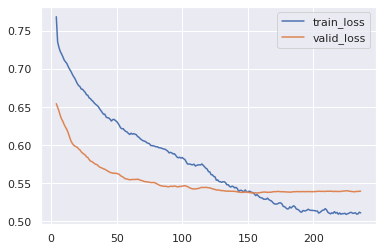

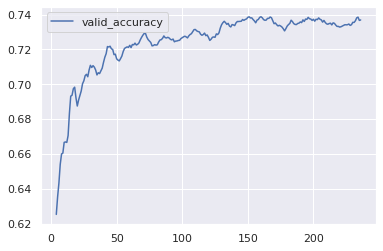

In [ ]:
plot_hist(hist, 5)

### WiC POS = 30

In [ ]:
@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for i, batch in enumerate(data_loader):
        loss, metric = eval_step(model, batch)
        losses.append(loss.item())
        results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)

model_wic = WiCClassifier(HypParams(), vectors, model_context, 
                            predict_pos=False).to('cuda')

optim_wic = torch.optim.Adam(model_wic.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_wic, factor=0.5, verbose=True)
#scheduler=None
best_model = {}
hist = {}

_ = train(train_loader, valid_loader, 
      model_wic, optim_wic, 
      train_step_3, 
      eval_step_3,
      260,
      scheduler=scheduler, 
      best_model_mode='accuracy', 
      best_model=best_model, hist=hist)

Epoch 0: Loss: 0.895941 		 Validation loss: 0.666299
BEST SCORE: tensor(0.5959, device='cuda:0')
Training average batch accuracy: 0.514125
Validation average batch accuracy: 0.595898
Epoch 1: Loss: 0.757352 		 Validation loss: 0.676078
Training average batch accuracy: 0.534250
Validation average batch accuracy: 0.580664
Epoch 2: Loss: 0.752785 		 Validation loss: 0.664498
BEST SCORE: tensor(0.6285, device='cuda:0')
Training average batch accuracy: 0.519750
Validation average batch accuracy: 0.628516
Epoch 3: Loss: 0.744010 		 Validation loss: 0.665782
Training average batch accuracy: 0.515375
Validation average batch accuracy: 0.595117
Epoch 4: Loss: 0.733827 		 Validation loss: 0.665823
Training average batch accuracy: 0.534750
Validation average batch accuracy: 0.597656
Epoch 5: Loss: 0.735531 		 Validation loss: 0.658017
Training average batch accuracy: 0.529625
Validation average batch accuracy: 0.628516
Epoch 6: Loss: 0.727760 		 Validation loss: 0.651869
BEST SCORE: tensor(0.6428

In [ ]:
best_model['best_score']

tensor(0.7422, device='cuda:0')

In [ ]:
{          'epoch': 178,
}, "/content/drive/MyDrive/Sapienza/WiC_pos_dim_30.pth" 

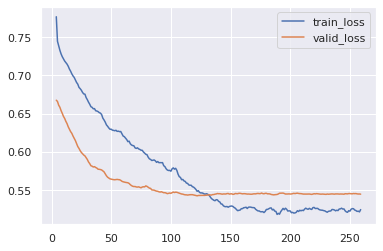

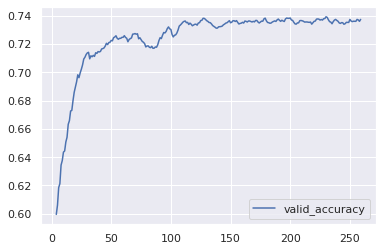

In [ ]:
plot_hist(hist, window=5)

### Multi-learning

In [ ]:
@torch.no_grad()
def evaluate(data_loader, model, eval_step):
    model.eval()
    results = []
    losses = []
    
    for i, batch in enumerate(data_loader):
        loss, metric = eval_step(model, batch)
        losses.append(loss.item())
        results.append(metric)

    return sum(losses) / len(losses), sum(results) / len(results)

model_wic = WiCClassifier(HypParams(), vectors, model_context, 
                            predict_pos=True
                          ).to('cuda')

optim_wic = torch.optim.Adam(model_wic.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_wic, factor=0.5, verbose=True)
#scheduler=None
best_model = {}
hist = {}

_ = train(train_loader, valid_loader, 
      model_wic, optim_wic, 
      train_step_3, 
      eval_step_3,
      260,
      scheduler=scheduler, 
      best_model_mode='accuracy', 
      best_model=best_model, hist=hist)

Epoch 0: Loss: 2.404471 		 Validation loss: 1.612491
BEST SCORE: tensor(0.5941, device='cuda:0')
Training average batch accuracy: 0.527000
Validation average batch accuracy: 0.594141
Epoch 1: Loss: 1.988850 		 Validation loss: 1.614282
BEST SCORE: tensor(0.6207, device='cuda:0')
Training average batch accuracy: 0.517875
Validation average batch accuracy: 0.620703
Epoch 2: Loss: 1.939136 		 Validation loss: 1.615588
Training average batch accuracy: 0.523750
Validation average batch accuracy: 0.613281
Epoch 3: Loss: 1.907889 		 Validation loss: 1.608220
BEST SCORE: tensor(0.6387, device='cuda:0')
Training average batch accuracy: 0.528500
Validation average batch accuracy: 0.638672
Epoch 4: Loss: 1.912886 		 Validation loss: 1.601080
Training average batch accuracy: 0.522250
Validation average batch accuracy: 0.606836
Epoch 5: Loss: 1.886110 		 Validation loss: 1.598670
Training average batch accuracy: 0.524125
Validation average batch accuracy: 0.617773
Epoch 6: Loss: 1.875783 		 Validat

In [ ]:
best_model['best_score']

tensor(0.7354, device='cuda:0')

In [ ]:
#torch.save({
            'epoch': 178,
            'model_state_dict': best_model['state_dict'],
            'optimizer_state_dict': optim_context.state_dict()
}, "/content/drive/MyDrive/Sapienza/WiC_multi_learn.pth" )

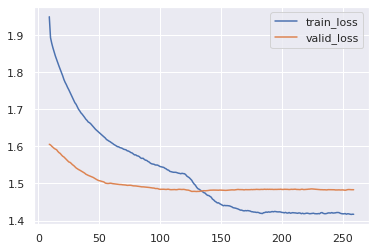

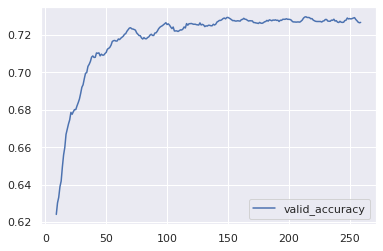

In [ ]:
plot_hist(hist, 10)

### Extra POS tags

In [ ]:
model_context.eval()
model_no_attn = NoAttention(HypParams(), vectors, model_context, 
                            predict_pos=False).to('cuda')

optim_no_attn = torch.optim.Adam(
    model_no_attn.parameters(),
    #lr=0.0001
    #weight_decay=0.001
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_context, factor=0.5, verbose=True)
#scheduler=None
best_model = {}
hist = {}

_ = train(train_loader, valid_loader, 
      model_no_attn, optim_no_attn, 
      train_step_3, 
      eval_step_3,
      260,
      scheduler=scheduler, 
      #best_model_mode='accuracy', 
      best_model=best_model, hist=hist)

Epoch 0: Loss: 0.894446 		 Validation loss: 0.674677
BEST SCORE: 0.6746766678988934
Training average batch accuracy: 0.511875
Validation average batch accuracy: 0.573438
Epoch 1: Loss: 0.772231 		 Validation loss: 0.672352
BEST SCORE: 0.6723519451916218
Training average batch accuracy: 0.519625
Validation average batch accuracy: 0.584766
Epoch 2: Loss: 0.740102 		 Validation loss: 0.677832
Training average batch accuracy: 0.527500
Validation average batch accuracy: 0.570312
Epoch 3: Loss: 0.735435 		 Validation loss: 0.659213
BEST SCORE: 0.6592127941548824
Training average batch accuracy: 0.533000
Validation average batch accuracy: 0.632812
Epoch 4: Loss: 0.735303 		 Validation loss: 0.656390
BEST SCORE: 0.6563903763890266
Training average batch accuracy: 0.530250
Validation average batch accuracy: 0.644922
Epoch 5: Loss: 0.728069 		 Validation loss: 0.662533
Training average batch accuracy: 0.544250
Validation average batch accuracy: 0.608594
Epoch 6: Loss: 0.727593 		 Validation loss

({'best_score': 0.5719214603304863,
  'state_dict': OrderedDict([('context_model.word_embeddings.weight',
                tensor([[ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
                        [-0.2554, -0.2572,  0.1317,  ..., -0.2329, -0.1223,  0.3550],
                        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],
                        ...,
                        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
                        [ 0.5117,  0.4524,  0.7137,  ...,  0.3651,  0.9864,  0.8735],
                        [ 0.7196,  0.4748,  0.8272,  ...,  0.4776,  0.4018,  0.3012]],
                       device='cuda:0')),
               ('context_model.rnn.weight_ih_l0',
                tensor([[ 0.0025, -0.0666, -0.0697,  ...,  0.0351,  0.0023, -0.0385],
                        [ 0.0069, -0.0936,  0.0338,  ...,  0.0266, -0.0367,  0.0062],
                        [-0.0181, -0.0112, -0.0264,  ...,  0.0434, -0.0105, -0.0173]